# Load components from file and search for string or ngrams in them

In [1]:
import pandas as pd

In [2]:
import numpy as np
import networkx as nx

In [3]:
import configparser
config = configparser.ConfigParser()
config.read('memeconfig.ini')
data_path = config['DEFAULT']['data_path']
pickle_data_path = config['DEFAULT']['pickle_data_path']
viz_data_path = config['DEFAULT']['viz_data_path']
series_name = 'LBDL'
#series_name = 'marseille'
viz_path = viz_data_path+series_name+'/c_components/'

In [4]:
def load_graph(filename):
    """ Load a graph from a json file.
    """
    from networkx.readwrite import json_graph
    import json
    with open(filename, "r") as f:
        data = json.load(f)
    # create a dic to translate ids to numbers for networkx
    dic_t = {}
    for idx,key in enumerate(data['nodes']):
        dic_t[key['id']] = idx
    # associate numbers to ids in links
    data['links'] = [
                {
                    'source': dic_t[link['source']],
                    'target': dic_t[link['target']]
                }
                for link in data['links']]
    H = json_graph.node_link_graph(data,directed=True,multigraph=False)
    return H

## Extract connected components and select the ones with particular words

In [5]:
# Extract components
graph_list = []
year = 2016
for month in range(1,10):
    json_filename = 'cc_'+series_name+'_'+str(year)+'_'+str(month)+'.json'
    filename = viz_path + json_filename
    G = load_graph(filename)
    #print(G.size())
    list_cc = [cc for cc in nx.weakly_connected_component_subgraphs(G)]
    print('nb of cc: {}'.format(len(list_cc)))
    [graph_list.append(cc) for cc in list_cc]

nb of cc: 19
nb of cc: 44
nb of cc: 7
nb of cc: 61
nb of cc: 138
nb of cc: 180
nb of cc: 95
nb of cc: 40
nb of cc: 37


In [33]:
# Select the components
selected_graphs = []
keywords = ['identité','fabriquée','pièces']
#keywords = ['services']
keywords = ['plus','secret']
#keywords = ['médiapart','mediapart']
keywords = ['duplicité','permanente']
for idx,HH in enumerate(graph_list):
    double=0
    for node,data in HH.nodes(data=True):
        if data['name'] in keywords and double==0 and HH.size()>3:
            print(idx,data['name'])
            selected_graphs.append(HH)
            double=1

131 permanente
139 duplicité
143 duplicité
586 duplicité
587 duplicité
593 permanente


### Extract full components from file into a dataframe

In [34]:
def get_component(component_id):
    json_filename = 'timecomponent_'+component_id+'.json'
    filename = viz_data_path + series_name +'/time_components/' + json_filename
    df = pd.read_json(filename,orient='records')
    return df

In [35]:
from random import choice
df_all = pd.DataFrame()
for G in selected_graphs:
    node1 = choice(G.nodes(data=True))
    component_id = node1[1]['component_id']
    df1 = get_component(component_id)
    print(len(df1))
    df_all = pd.concat([df_all,df1])

44188
4443
4999
5301
2476
305


In [36]:
len(df_all)

61712

## Extract bigrams from the dynamic component

In [37]:
media_list = ['Twitter','Website','Facebook','Media','Blog','Comment','Forum','Instagram']

In [38]:
df_meme = pd.DataFrame()

keywords = ['identité fabriquée']
keywords = ['plus secret']
#keywords = ['mediapart']
keywords = ['duplicité permanente']
for Index,row in df_all.iterrows():
    bigram = [row['name']]#.split()
    #bigram = row['name'].split()
    if set(bigram) & set(keywords):
        #print(bigram)
        #pd.concat([df_meme,row])
        df_meme.loc[Index,'name'] = row['name']
        df_meme.loc[Index,'occur'] = row['occur']
        df_meme.loc[Index,'hour'] = row['hour']
        df_meme.loc[Index,'day'] = row['day']
        df_meme.loc[Index,'month'] = row['month']
        df_meme.loc[Index,'year'] = row['year']
        df_meme.loc[Index,'main_media'] = row['main_media']
        row = row.fillna(0)
        for media in media_list:
            if media in row.keys():
                df_meme.loc[Index,media] = int(row[media])
        df_meme.day = df_meme.day.astype(int)
        df_meme.month = df_meme.month.astype(int)
        df_meme.year = df_meme.year.astype(int)
        df_meme.hour = df_meme.hour.astype(int)
        df_meme.occur = df_meme.occur.astype(int)
# Add a column date and sort the bigrams chronologically
if not df_meme.empty:
    import datetime
    df_meme['date'] = df_meme.apply(lambda row : datetime.datetime(row.year,row.month,row.day,row.hour),axis=1)
    df_meme = df_meme.sort_values('date').reset_index()
print(df_meme)

    index                  name  occur  hour  day  month  year main_media  \
0   40324  duplicité permanente      1     9    9      5  2016   Facebook   
1   19668  duplicité permanente      1    10    9      5  2016    Website   
2    7039  duplicité permanente      2    23    9      5  2016    Website   
3    3196  duplicité permanente      2     0   10      5  2016    Website   
4    8014  duplicité permanente      1     5   10      5  2016    Website   
5   15130  duplicité permanente      1    11   10      5  2016    Website   
6   42133  duplicité permanente      1    12   10      5  2016    Website   
7   40403  duplicité permanente      1    13   10      5  2016    Website   
8    6686  duplicité permanente      2    16   10      5  2016    Website   
9    5630  duplicité permanente      2    18   10      5  2016    Website   
10   1617  duplicité permanente      3     0   11      5  2016    Website   
11    163  duplicité permanente     10     4   11      5  2016    Website   

In [39]:
len(df_meme)

21

In [40]:
print("begin: {}, end: {}".format(df_meme['date'][0],df_meme['date'][len(df_meme)-1]))

begin: 2016-05-09 09:00:00, end: 2016-09-27 07:00:00


In [41]:
# save the dataframe as a csv file
#df_meme.to_csv('BNloitravail.csv')

### BY day

In [42]:
bigram_column_name = 'occur of '+df_meme['name'].iloc[0]
#bigram_column_name = 'occur of porno'
df_2=pd.DataFrame()
df_2['date'] = df_meme['date']
df_2[bigram_column_name] = df_meme['occur']
#df_2['main_media'] = df_meme['main_media']
for media in media_list:
    if media in row.keys():
            df_2[media] = df_meme[media]
df_2.index = df_meme['date']
#df_2['bigram'] = df_meme['name']

In [50]:
df_2

,date,occur of duplicité permanente,Twitter,Website,Facebook,Media,Blog,Forum,Instagram
date,,,,,,,,,
2016-05-09 09:00:00,2016-05-09 09:00:00,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-05-09 10:00:00,2016-05-09 10:00:00,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-05-09 23:00:00,2016-05-09 23:00:00,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2016-05-10 00:00:00,2016-05-10 00:00:00,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2016-05-10 05:00:00,2016-05-10 05:00:00,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-05-10 11:00:00,2016-05-10 11:00:00,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-05-10 12:00:00,2016-05-10 12:00:00,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-05-10 13:00:00,2016-05-10 13:00:00,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-05-10 16:00:00,2016-05-10 16:00:00,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0


In [58]:
df_3 = pd.DataFrame()
df_3 = df_2.resample('D').agg({bigram_column_name:'sum', 'Twitter':'sum','Website':'sum',
                              'Facebook':'sum','Media':'sum','Blog':'sum',#'Comment':'sum',
                              'Forum':'sum','Instagram':'sum'}).fillna(0)
df_3[bigram_column_name] = df_3[bigram_column_name].astype(int)
for media in media_list:
    if media in row.keys():
            df_3[media] = df_3[media].astype(int)

In [60]:
df_3 

,Media,Instagram,occur of duplicité permanente,Website,Blog,Forum,Facebook,Twitter
date,,,,,,,,
2016-05-09,0,0,4,3,0,0,1,0
2016-05-10,0,0,10,10,0,0,0,0
2016-05-11,0,0,29,29,0,0,0,0
2016-05-12,0,0,0,0,0,0,0,0
2016-05-13,0,0,0,0,0,0,0,0
2016-05-14,0,0,0,0,0,0,0,0
2016-05-15,0,0,0,0,0,0,0,0
2016-05-16,0,0,0,0,0,0,0,0
2016-05-17,0,0,0,0,0,0,0,0


In [59]:
df_3.keys()

Index(['Media', 'Instagram', 'occur of duplicité permanente', 'Website',
       'Blog', 'Forum', 'Facebook', 'Twitter'],
      dtype='object')

In [61]:
# save the dataframe as a csv file
#df_3.to_csv('LBDLidentitefabriquee_2016_day_media.csv')
#df_3.to_csv('LBDLplussecret_2016_day_media.csv')
df_3.to_csv('LBDLduplicitepermanente_2016_day_media.csv')


### Visualization

<IPython.core.display.Javascript object>


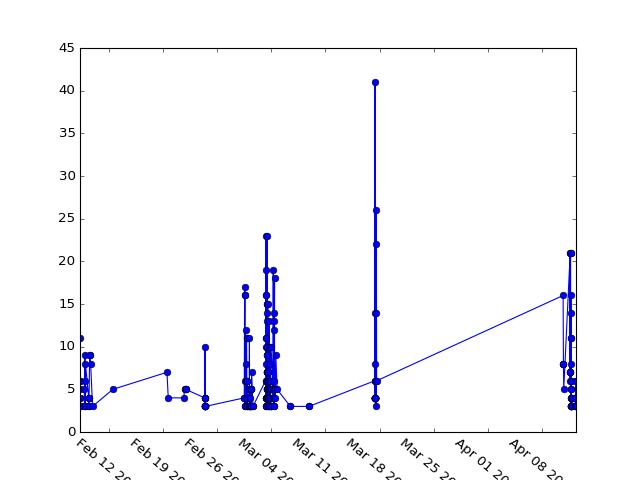

In [40]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot_date(df_meme['date'],df_meme['occur'],linestyle='solid')
plt.xticks(rotation=-40)
plt.show()

### Construct the graph from the bigrams

In [37]:
def datediffnorm(date,start_date,stop_date):
    datediff = date-start_date
    date_len = stop_date-start_date
    datediff_norm = datediff.total_seconds()/date_len.total_seconds()
    return datediff_norm

In [38]:
start_date = df_meme['date'][0]
stop_date = df_meme['date'][len(df_meme)-1]
H = nx.DiGraph()
for row in df_meme.itertuples():
    bigram = row.name.split()
    date = row.date
    word1_id = bigram[0]+date.strftime("%Y-%m-%d-%H")
    word2_id = bigram[1]+date.strftime("%Y-%m-%d-%H")
    date = row.date
    occur = int(row.occur)
    date_norm = datediffnorm(date,start_date,stop_date)
    H.add_node(word1_id, name = bigram[0], date=date.strftime("%Hh %d-%m-%Y"),time_loc=date_norm,
              nb_occur =occur)
    H.add_node(word2_id, name = bigram[1], date=date.strftime("%Hh %d-%m-%Y"),time_loc=date_norm,
              nb_occur=occur)
    H.add_edge(word1_id,word2_id)
    datebefore = date-datetime.timedelta(hours=1)
    word1before = bigram[0]+datebefore.strftime("%Y-%m-%d-%H")
    if H.has_node(word1before):
        H.add_edge(word1before,word1_id)
    word2before = bigram[1]+datebefore.strftime("%Y-%m-%d-%H")
    if H.has_node(word2before):
        H.add_edge(word2before,word2_id)   
    dateafter = date+datetime.timedelta(hours=1)
    word1after = bigram[0]+dateafter.strftime("%Y-%m-%d-%H")
    if H.has_node(word1after):
        H.add_edge(word1_id,word1after)      
    word2after = bigram[1]+dateafter.strftime("%Y-%m-%d-%H")
    if H.has_node(word2after):
        H.add_edge(word2_id,word2after)      

In [39]:
# Save the data
H.graph['series_name'] = series_name
H.graph['start_date'] = df_meme['date'][0].strftime("%d-%m-%Y-%H:00")
H.graph['end_date'] = df_meme['date'][len(df_meme)-1].strftime("%d-%m-%Y-%H:00")
import memebox.multilayergraph as mlg
jsonfile = 'viz/cc_evolution_marseille.json'
mlg.save_graph(H,jsonfile)